In [1]:
# loads numpy and matplotlib
%pylab inline

# imports functions to interact with operating system
import os

import scipy as sp
from numba import jit

Populating the interactive namespace from numpy and matplotlib


/home/nescivi/git/projects/sussex/chrysalisConceptors/workshop


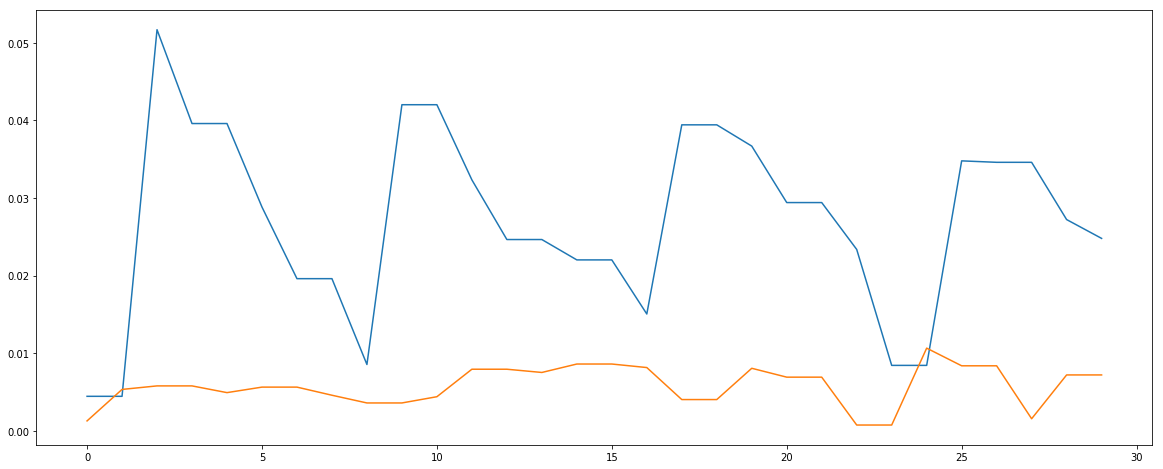

In [2]:
# get current working path
cwd = os.getcwd()
print( cwd )

# load gesture 1
gesture1 = np.loadtxt(cwd + '/gesturedata_0.txt')
gesture2 = np.loadtxt(cwd + '/gesturedata_1.txt')

# plot the two gestures
figsize(20,8);

plot( gesture1 )
plot( gesture2 )

0.0516839488978


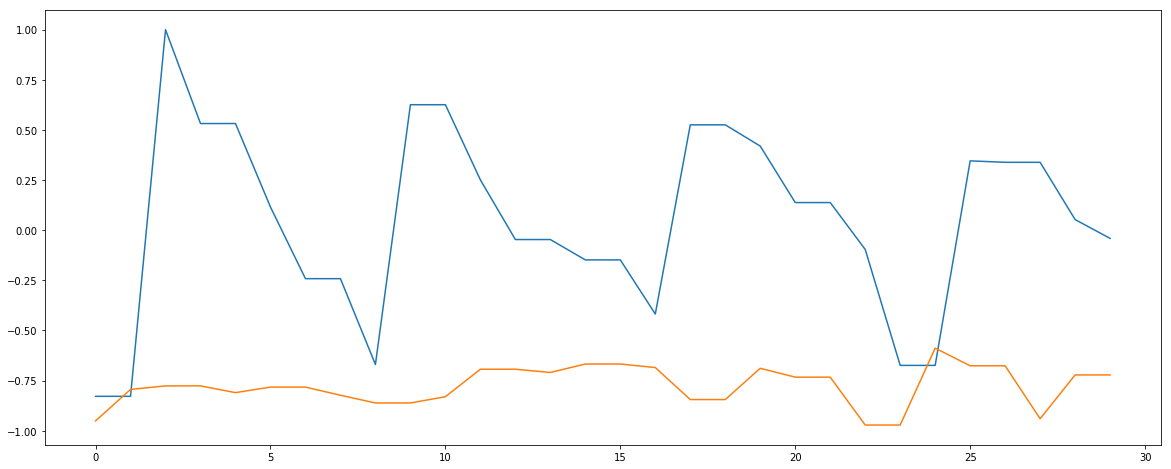

In [3]:
# to normalize the two gestures to each other, we find the maximum value in the two arrays:
maxValue = max( max(gesture1), max(gesture2) )

print( maxValue )

# scale the gestures and make bipolar:

gesture1 = (gesture1 / maxValue)*2 - 1;
gesture2 = (gesture2 / maxValue)*2 - 1;

# plot it again: looks the same, but scale on the y-axis is now between -1 and 1
plot( gesture1 )
plot( gesture2 )

In [4]:
#define some useful functions
@jit
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [5]:

def makeClassifierNetwork(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    W = Wstar
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    
    for i_pattern in range(p['patts'].size):
        print('Observing pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)

    return locals()

params = {'N':100, 'NetSR':1.9, 'NetinpScaling':20,'BiasScaling':0.6,
         'washoutLength':300, 'learnLength':30, 
          'LR': 0.6,
#           'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
          'patts':np.array([lambda x:pLoop(x,gesture1), lambda x: pLoop(x,gesture2)])
         }

net = makeClassifierNetwork(params)


Observing pattern  0
Observing pattern  1


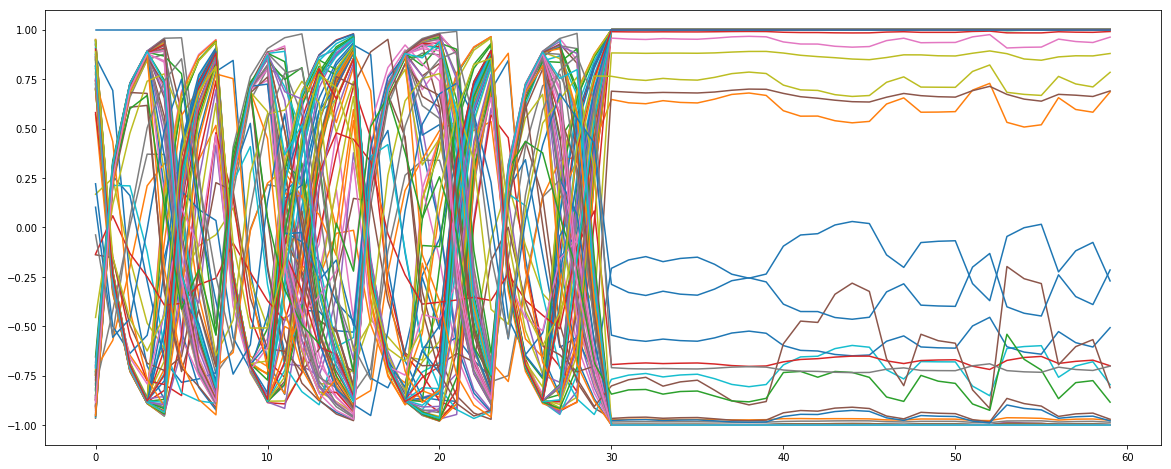

In [6]:
figsize(20,8)
plot(net['allTrainxArgs'].T)
None

In [7]:
#define functions to compute and test the conceptors

def computeConceptors(p, net, alphas):
    print('Computing conceptors, alphas: ', alphas)
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = net['patternRs'][0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)
    return locals()

import scipy.spatial.distance as dist


def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
    x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    cx_CTestPL = np.zeros((p['patts'].size,recallTestLength))
    pat_CTestPL = np.zeros((1,recallTestLength))
    
    for i_pattern in range(p['patts'].size):
        patt = p['patts'][i_pattern]
        x = np.zeros((p['N'],1))
        for n in range(recallTestLength + p['washoutLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x)) + (cNet['net']['Win'].dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
            if (n > p['washoutLength']):
                pat_CTestPL[0,n-p['washoutLength'] ] = u
                C = cNet['Cs'][0,0]
                C2 = cNet['Cs'][0,1]
                cx = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
                cx_CTestPL[0,n-p['washoutLength']] = cx
                cx2 = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
#                 cx2 = x.T.dot(C2.dot(x))
                cx_CTestPL[1,n-p['washoutLength']] = cx2

        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) + ", alphas: " + str(cNet['alphas']))
#         plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        plot(pat_CTestPL.T)
        plot(cx_CTestPL.T)
        classificationScore = np.sum(cx_CTestPL[i_pattern] > cx_CTestPL[1 - i_pattern]) / cx_CTestPL[0].size
        separation = dist.euclidean(cx_CTestPL[i_pattern],cx_CTestPL[1-i_pattern])
        print("Pattern ", str(i_pattern), " classification score: ", classificationScore, ", separation: ", separation)
        #testing

    return locals()


Computing conceptors, alphas:  [ 50.69300621  50.80996914]
Pattern  0  classification score:  0.99 , separation:  214.98547726120967
Pattern  1  classification score:  0.99 , separation:  3.617824870096246
Computing conceptors, alphas:  [ 32.34485025  87.58402099]
Pattern  0  classification score:  0.99 , separation:  213.5664171268505
Pattern  1  classification score:  0.99 , separation:  5.434625093846822
Computing conceptors, alphas:  [  7.07159457  72.80104783]
Pattern  0  classification score:  0.99 , separation:  208.89793133800185
Pattern  1  classification score:  0.99 , separation:  25.9915443646219
Computing conceptors, alphas:  [ 52.09884867  84.98734516]
Pattern  0  classification score:  0.99 , separation:  213.87549566398684
Pattern  1  classification score:  0.99 , separation:  3.554422839881868
Computing conceptors, alphas:  [ 17.96575923  19.73887984]
Pattern  0  classification score:  0.99 , separation:  216.6122502393921
Pattern  1  classification score:  0.99 , sepa

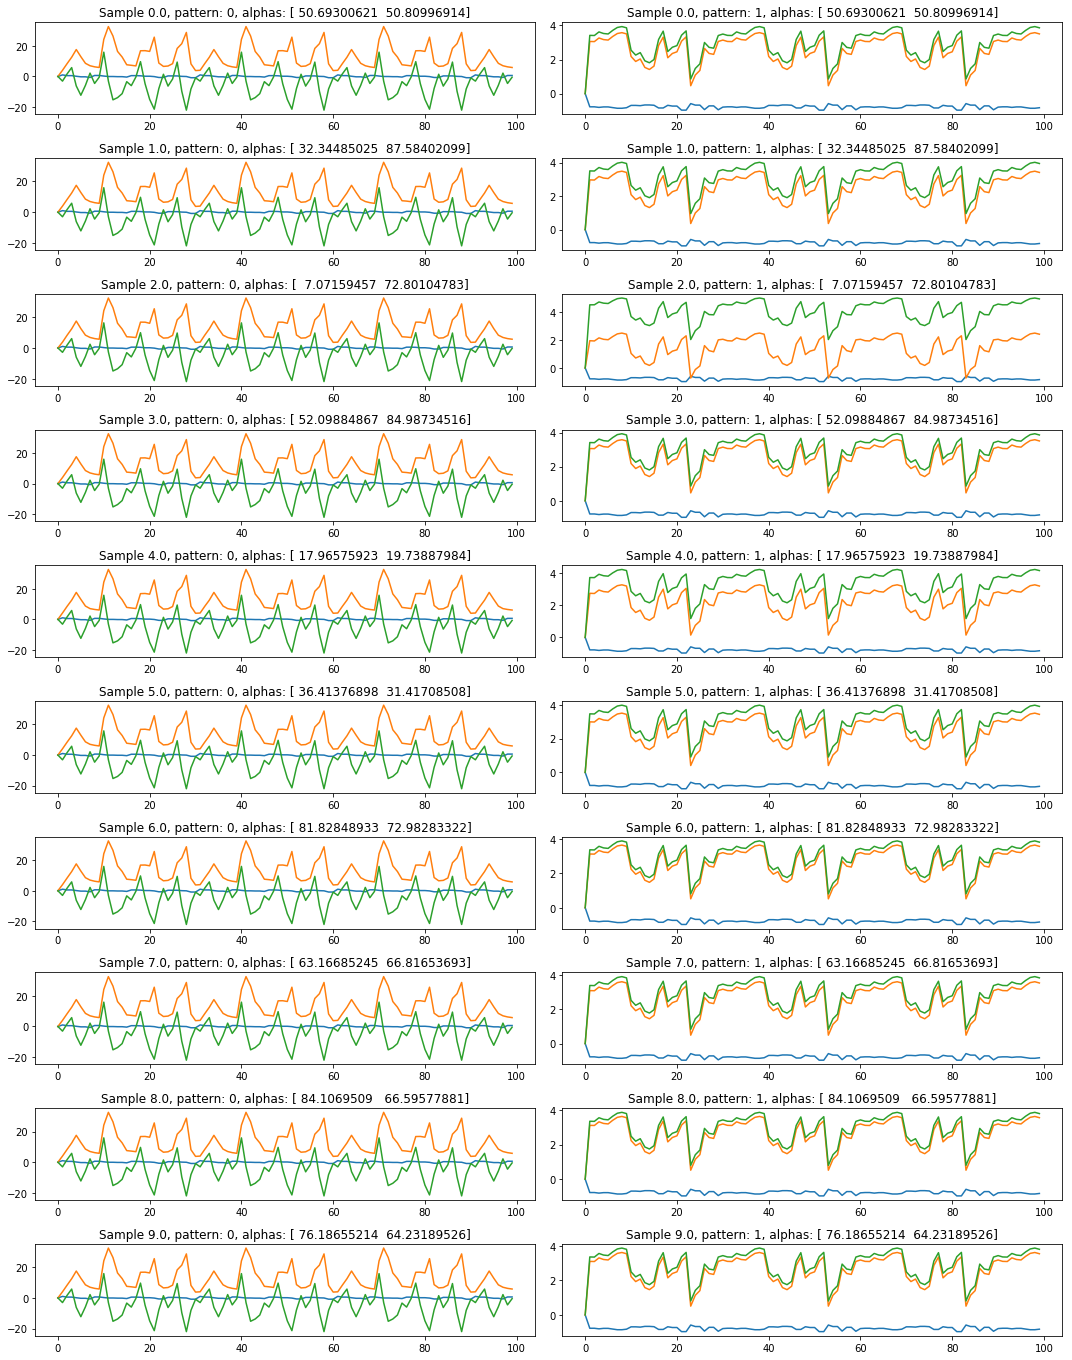

In [8]:
conceptorSampleSize = 10
conceptorNets = np.zeros(conceptorSampleSize, dtype=np.object)
figsize(15,conceptorSampleSize * 1.9)
for i_cnet in range(conceptorSampleSize):
    conceptorNets[i_cnet] = computeConceptors(params, net, np.random.random(2) * 100)
    pq = plotConceptorPatterns(params, conceptorNets[i_cnet], conceptorSampleSize, i_cnet * 2, 100)
plt.tight_layout();


In [9]:
#which are the best apertures?
bestConceptor = conceptorNets[2]
import dill as pickle
with open(r"net.pickle", "wb") as output_file:
    pickle.dump(bestConceptor, output_file, protocol=0)